<a href="https://colab.research.google.com/github/Erifai/NLP_TEXT_MINING_COVID_SEVERITY_FACTORS/blob/main/PPD_Fouille_de_texte_pour_lexploration_des_facteurs_de_s%C3%A9v%C3%A9rit%C3%A9_du_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Literature Clustering

# Préparation de l'environnement

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
#!pip install Bio
#import Bio
#from Bio import Entrez
#from Bio import Medline
#!pip install matplotlib==3.2.0
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#----------------------------------------------
#Download the spacy bio parser
from IPython.utils import io
#with io.capture_output() as captured:
#  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
#----------------------------
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()
#----------------------------
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step
#--------------------------------------------------

#import nltk
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


/home/kamel/.local/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_sci_lg' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
#%matplotlib inline
#!pip install coclust
from scipy.io import loadmat
from sklearn.metrics import (adjusted_rand_score as ari,
                             normalized_mutual_info_score as nmi)

from coclust.coclustering import (CoclustMod, CoclustSpecMod, CoclustInfo)
from coclust.io.data_loading import load_doc_term_data
from coclust.evaluation.internal import best_modularity_partition
#from coclust.evaluation.external import accuracy
from coclust.io.notebook import(input_with_default_int, input_with_default_str)
from coclust.visualization import (plot_max_modularities, 
                                   plot_intermediate_modularities,
                                   plot_cluster_top_terms, 
                                   get_term_graph, 
                                   plot_cluster_sizes)


#!pip install coclust
from coclust.coclustering import CoclustMod
from coclust.io.data_loading import load_doc_term_data
from coclust.visualization import (plot_reorganized_matrix,
                                  plot_cluster_top_terms,
                                  plot_max_modularities,
                                  get_term_graph,
                                  plot_convergence)
from coclust.evaluation.internal import best_modularity_partition
from coclust.coclustering import CoclustMod
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

#### specification du nombre de fichiers a lire : 

In [4]:
import Bio
from Bio import Entrez
from Bio import Medline

In [15]:
max_searchs = 5000
terms = "coronavirus covid covid19 severity obesity"


In [16]:
Entrez.email = 'A.N.Other@example.com'
ids=[[]]
print("max_searchs : ",max_searchs)
for i in range(0,max_searchs,100):
  print(i," ", end='')
  h = Entrez.esearch(db='pubmed', retmax=100,retstart=i, term=terms)
  result = Entrez.read(h)
  ids.append(result['IdList'])
h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
records = Medline.parse(h)

max_searchs :  5000
0  100  200  300  400  500  600  700  800  900  1000  1100  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800  4900  

In [17]:
# dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}

def append_records(records):
    dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
    for idx, entry in enumerate(records):

        if idx >max_searchs:
            break
        #--------------------------------------------------
        try:
            dict_['paper_id'].append(entry["PMID"])
        except Exception as e:
            dict_['paper_id'].append("")
        #--------------------------------------------------      
        try:
            dict_['abstract'].append(entry["AB"])
            # also create a column for the summary of abstract to be used in a plot
            if len(entry["AB"]) == 0: 
                # no abstract provided
                dict_['abstract_summary'].append("Not provided.")
            elif len(entry["AB"].split(' ')) > 100:
                # abstract provided is too long for plot, take first 100 words append with ...
                info = entry["AB"].split(' ')[:100]
                summary = get_breaks(' '.join(info), 40)
                dict_['abstract_summary'].append(summary + "...")
            else:
                # abstract is short enough
                summary = get_breaks(entry["AB"], 40)
                dict_['abstract_summary'].append(summary)
        except Exception as e:
            dict_['abstract'].append("")  
            dict_['abstract_summary'].append("Not provided.")

        #--------------------------------------------------      
        try:
            dict_['body_text'].append(entry["AB"])
        except Exception as e:
            dict_['body_text'].append("") 
        #--------------------------------------------------
        try:
            # if more than one author
            authors = entry['AU'][0].split(',')
            if len(authors) > 2:
                # if more than 2 authors, take them all with html tag breaks in between
                dict_['authors'].append(get_breaks('. '.join(authors), 40))
            else:
                # authors will fit in plot
                dict_['authors'].append(". ".join(authors))
        except Exception as e:
            # if only one author - or Null valie
            try : 
                dict_['authors'].append(entry['AU'][0])
            except Exception as e:
                dict_['authors'].append("")


        #-------------------------------------------------- 
        # add the title information, add breaks when needed
        try:
            title = get_breaks(entry['TI'][0], 40)
            dict_['title'].append(title)
        # if title was not provided
        except Exception as e:
            try:
                dict_['title'].append(entry['TI'][0])
            except Exception as e:
                dict_['title'].append("")
        #-------------------------------------------------- 
        # add the journal information
        try:
            dict_['journal'].append(entry['PT'][0])
        except Exception as e:
            dict_['journal'].append("")


    return dict_

In [18]:
dict_1 = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
print("max iterations : ",len(ids))
for i in range(1,len(ids)):
    print(i)
    h = Entrez.efetch(db='pubmed', id=ids[i], rettype='medline', retmode='json')
    records = Medline.parse(h)

    token = append_records(records)
    dict_1["paper_id"] = dict_1["paper_id"]+token["paper_id"]
    dict_1["abstract"] = dict_1["abstract"] + token["abstract"]
    dict_1["body_text"] =  dict_1["body_text"] +token["body_text"]
    dict_1["authors"] = dict_1["authors"] + token["authors"]
    dict_1["title"] =dict_1["title"] + token["title"]
    dict_1["journal"] =dict_1["journal"] +token["journal"]
    dict_1["abstract_summary"]=dict_1["abstract_summary"]+token["abstract_summary"]

max iterations :  51
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [19]:
len(dict_1["paper_id"]),len(dict_1["abstract"]),len(dict_1["body_text"])  ,len(dict_1["authors"]) ,len(dict_1["title"]) ,len(dict_1["journal"]),len(dict_1["abstract_summary"])

(756, 756, 756, 756, 756, 756, 756)

In [20]:
df_covid = pd.DataFrame(dict_1, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])

In [21]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          756 non-null    object
 1   abstract          756 non-null    object
 2   body_text         756 non-null    object
 3   authors           756 non-null    object
 4   title             756 non-null    object
 5   journal           756 non-null    object
 6   abstract_summary  756 non-null    object
dtypes: object(7)
memory usage: 41.5+ KB


## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [22]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,35419453,Background: The coronavirus disease 2019 (COVI...,Background: The coronavirus disease 2019 (COVI...,Claassen N,E,Journal Article,Background: The coronavirus disease 2019<br>(...,260,260,160
1,35416467,BACKGROUND: Although older adults aret ahigh r...,BACKGROUND: Although older adults aret ahigh r...,Kokkoris S,O,Journal Article,BACKGROUND: Although older adults aret ahigh<...,252,252,178
2,35396748,INTRODUCTION: Interest revolving around corona...,INTRODUCTION: Interest revolving around corona...,Koupaei M,C,Journal Article,INTRODUCTION: Interest revolving around<br>co...,295,295,196
3,35393674,"The interim results of the large, multinationa...","The interim results of the large, multinationa...",Pawar A,A,Journal Article,"The interim results of the large,<br>multinat...",199,199,142
4,35390025,OBJECTIVE: This study examines the value of ri...,OBJECTIVE: This study examines the value of ri...,Salvy SJ,H,Journal Article,OBJECTIVE: This study examines the value of<b...,180,180,125


In [23]:
df_covid['abstract'][0]

'Background: The coronavirus disease 2019 (COVID-19) pandemic in tertiary hospitals from South Africa and world wide have been well described, but limited data are published on the findings. This article aimed to describe patients admitted to a large district hospital in Cape Town, South Africa, during the first wave of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) Infections. To compare the clinical features and further investigate survivors and deceased COVID-19 patients. Methods: A single centre retrospective review of clinical records and laboratory data of patients admitted with a positive SARS-CoV-2 polymerase chain reaction (PCR) from April 2020 to August 2020. Results: A total of 568 patients with a positive SARS-CoV-2 PCR were admitted to the study centre for one night or longer and of these patients 154 (27%) died of COVID-19. The median age of patients who died of COVID-19 was 66 years and 53 years for survivors. Hypertension, diabetes mellitus and obesity wer

In [37]:
df_covid['abstract'].describe(include='all')

count                                                   679
unique                                                  679
top       Background: The coronavirus disease 2019 (COVI...
freq                                                      1
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that there are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

In [38]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count                                                   679
unique                                                  679
top       Background: The coronavirus disease 2019 (COVI...
freq                                                      1
Name: abstract, dtype: object

In [39]:
df_covid['body_text'].describe(include='all')

count                                                   679
unique                                                  679
top       Background: The coronavirus disease 2019 (COVI...
freq                                                      1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [40]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,679.000000,679.000000,679.000000
mean,240.979381,240.979381,152.879234
std,103.331138,103.331138,52.625466
min,0.000000,0.000000,0.000000
25%,187.000000,187.000000,122.000000
50%,236.000000,236.000000,149.000000
75%,274.000000,274.000000,175.000000
max,1112.000000,1112.000000,573.000000


# Data Pre-processing

### dataset size reduction :

we can use only a part of our dataset to speedup the execution

In [41]:
#df = df_covid.sample(4000, random_state=42)
df = df_covid

### Delete Null values   :

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [42]:
df["body_text"].dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679 entries, 0 to 713
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             679 non-null    object
 1   abstract             679 non-null    object
 2   body_text            679 non-null    object
 3   authors              679 non-null    object
 4   title                679 non-null    object
 5   journal              679 non-null    object
 6   abstract_summary     679 non-null    object
 7   abstract_word_count  679 non-null    int64 
 8   body_word_count      679 non-null    int64 
 9   body_unique_words    679 non-null    int64 
 10  language             679 non-null    object
dtypes: int64(3), object(8)
memory usage: 63.7+ KB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [43]:
!pip install tqdm
import tqdm
!pip install langdetect
import langdetect
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0
# hold label - language
languages = []
# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e: 
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    # get the language    
    languages.append(lang)

100%|██████████| 679/679 [00:02<00:00, 321.48it/s]


In [44]:
from pprint import pprint
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang) 
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 679

{'en': 678, 'hu': 1}


Lets take a look at the language distribution in the dataset

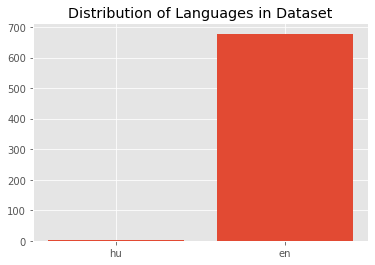

In [45]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [46]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678 entries, 0 to 713
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             678 non-null    object
 1   abstract             678 non-null    object
 2   body_text            678 non-null    object
 3   authors              678 non-null    object
 4   title                678 non-null    object
 5   journal              678 non-null    object
 6   abstract_summary     678 non-null    object
 7   abstract_word_count  678 non-null    int64 
 8   body_word_count      678 non-null    int64 
 9   body_unique_words    678 non-null    int64 
 10  language             678 non-null    object
dtypes: int64(3), object(8)
memory usage: 63.6+ KB


In [47]:
#Download the spacy bio parser
from IPython.utils import io
with io.capture_output() as captured:
  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
#----------------------------
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()
#----------------------------
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [48]:
import string
#punctuations
punctuations = string.punctuation
#stopwords
stopwords = list(STOP_WORDS)
print("----------------------------------")
print("stopwords  :" )
print(stopwords)
print("----------------------------------")
print("punctuations  : ")
print(punctuations)

----------------------------------
stopwords  :
['still', '’ve', 'afterwards', '’m', 'between', 'whereafter', 'three', 'this', 'no', 'anywhere', 'mostly', 'front', 'then', 'while', 'otherwise', 'been', 'their', 'bottom', 'unless', 'both', 'my', 'name', 'hers', 'please', 'really', 'toward', "'m", 'also', 'should', 'as', 'him', 'almost', 'mine', 'namely', 'although', 'would', 'again', 'show', 'others', 'own', 'throughout', 'his', 'had', 'seemed', 'over', 'always', '‘d', 'much', 'since', 'give', 'nobody', 'ourselves', '‘ve', 'a', 'nevertheless', 'hereafter', 'because', 'using', 'indeed', '‘re', 'anyone', 'take', 'first', 'together', 'make', 'everywhere', 'former', 'towards', 'ours', 'third', 'to', 'them', 'become', 'under', 'each', 'perhaps', 'very', 'being', 'twelve', 'anything', 'serious', 'hence', 'nowhere', 'per', 'many', 'thence', 'various', 'formerly', 'us', 'by', 'might', 'eight', 'you', 'behind', 'your', 'hundred', 'before', 'say', 'they', 'is', 'whom', 'on', 'whereupon', 'another

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.


In [49]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www' , 'the' , 'THE' ,"19" ,"-"]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

### Stop words , Ponctuation and Lemmatizing

In [50]:
import spacy
import re
nlp = en_core_web_lg.load()
def spacy_process(texte):

    #URLs
    string = re.sub(r"https?://\S+|www.\S+",'',texte)
    #html 
    string = re.sub(r'<.*?>','',string)
    #Numbers
    string = re.sub(r'[0-9]+','',string) 

    mytokens = nlp(string)
    mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text.lower() not in stopwords and word.text.lower() not in punctuations]
    mytokens2 = " ".join([i for i in mytokens2])
    return mytokens2
df["processed_text"] = df["body_text"].apply(spacy_process)

<ipython-input-50-6ab7ca468df0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed_text"] = df["body_text"].apply(spacy_process)


In [51]:
#df["processed_text"].to_csv("text_cleaned.csv")


In [65]:
df.to_csv("C:\\Users\\Seyf_GOUMEIDA\\Desktop\\PPD\\new_text_cleaned.csv")


### Exemple for lemmatizing with Lemma

it doesn't detect the conjugaison of the verbs so we need to use an other lemmmatizer

In [59]:
test1 = spacy_process("vaccinations")
test2 = spacy_process("vaccination")
test3 = spacy_process("vaccinating")
test4 = spacy_process("vaccinated")
print("vaccinations  :" , test1)
print("vaccination  :" ,test2)
print("vaccinating  :" ,test3)
print("vaccinated  :" ,test4)

vaccinations  : vaccination
vaccination  : vaccination
vaccinating  : vaccinate
vaccinated  : vaccinate


In [60]:
# processed_text = df["processed_text"]
# body_text = df["body_text"]

# for i in range(0,10):
#     print("body_text[i]")
#     print(body_text[i])
#     print("")
#     print("processed_text[i]")
#     print(processed_text[i])
#     print("")
#     print("----------------------------------------------------------")



### Let's take a look at word count in the papers

In [61]:
import seaborn as sns

/home/kamel/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     678.000000
mean      241.333333
std       102.994677
min         0.000000
25%       187.000000
50%       236.500000
75%       274.000000
max      1112.000000
Name: body_word_count, dtype: float64

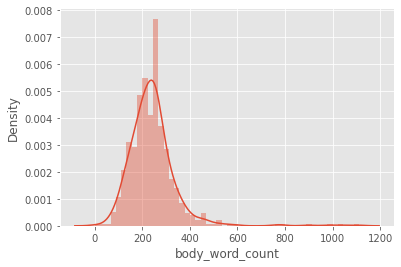

In [62]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

/home/kamel/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    678.000000
mean     153.103245
std       52.339348
min        0.000000
25%      123.000000
50%      149.000000
75%      175.000000
max      573.000000
Name: body_unique_words, dtype: float64

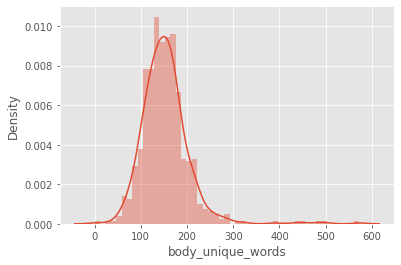

In [63]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

# Vectorisation

In [64]:
import pandas as pd
df = pd.read_csv('./new_text_cleaned.csv')
#df = pd.read_csv("/content/text_cleaned.csv")
df.drop(columns="Unnamed: 0",inplace=True)
df.dropna(inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: './new_text_cleaned.csv'

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text):
    
    global vectorizer 
    X = vectorizer.fit_transform(text)
    return X
#-----------------------------------------------------------
text = df['processed_text'].values
vectorizer = TfidfVectorizer(max_features= 2 ** 12)
X = vectorize(text)
X.shape

(678, 4096)

In [67]:
# on doit vérifier si le vectorizer prend 2**12 premiers mots ou bien par nombre d'occurences 
all_terms_tfidf = vectorizer.get_feature_names()

/home/kamel/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Coclust

In [68]:
# ** Compute the final coClust modularity on a range of number of clusters **

# -- range of number of clusters
# ---- get min
min_cluster_nbr = 2
max_cluster_nbr = 9
range_n_clusters = range(min_cluster_nbr, (max_cluster_nbr+1))

# -- Number of random initialization per cluster number
n_rand_init = 1

# --  max modularity for all models
model, all_max_modularities = best_modularity_partition(X,range_n_clusters, n_rand_init)

Computing coclust modularity for a range of cluster numbers =
 2 ...
 3 ...
 4 ...
 5 ...
 6 ...
 7 ...
 8 ...
 9 ...
 All done !


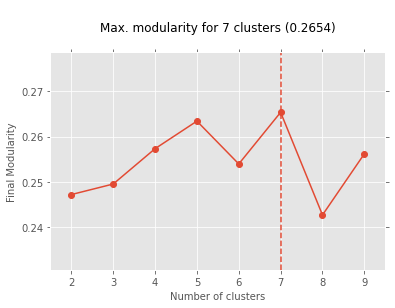

In [69]:
# ** Plot all final modularities **
plot_max_modularities(all_max_modularities, range_n_clusters)

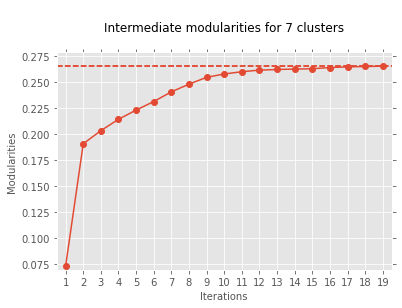

In [70]:
# ** Plot intermediate modularities for the best CoClust final modularity **
plot_intermediate_modularities(model)

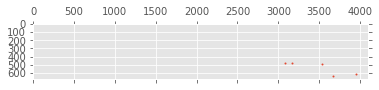

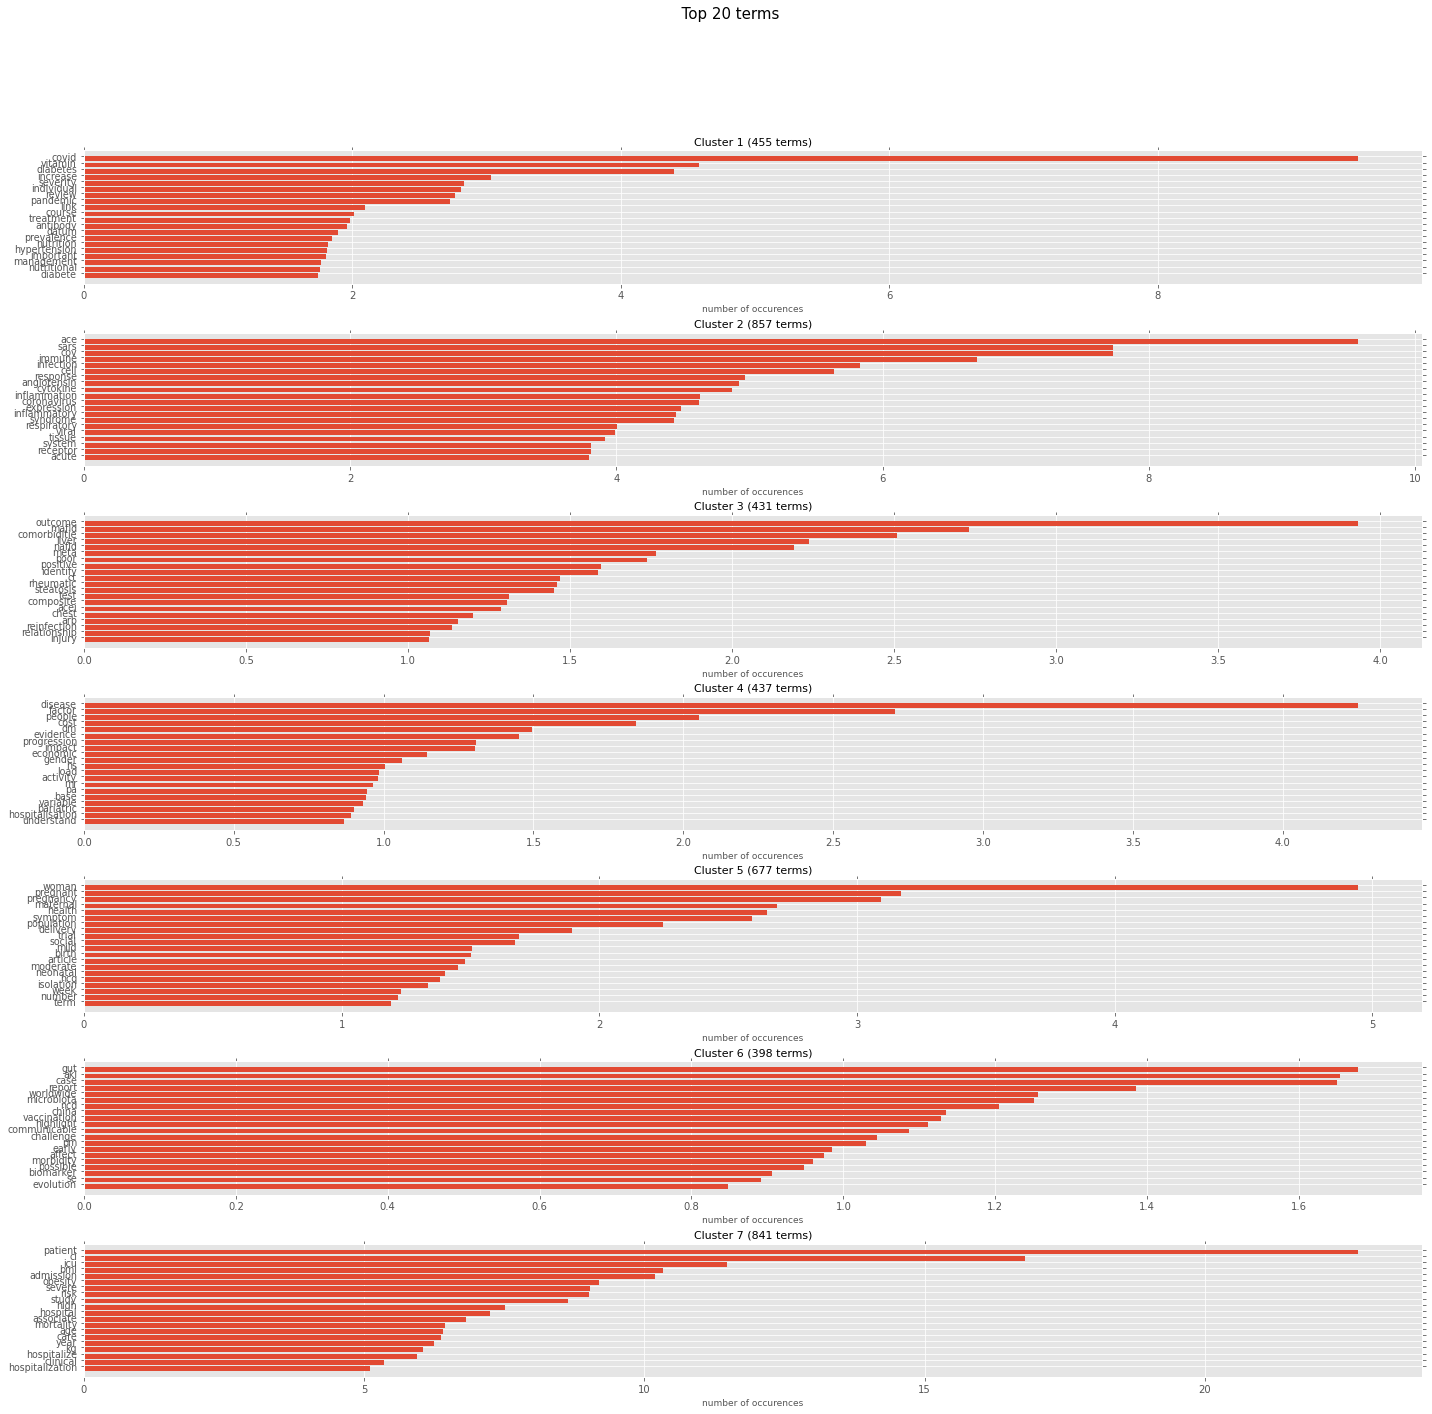

taille de chaque cluster :


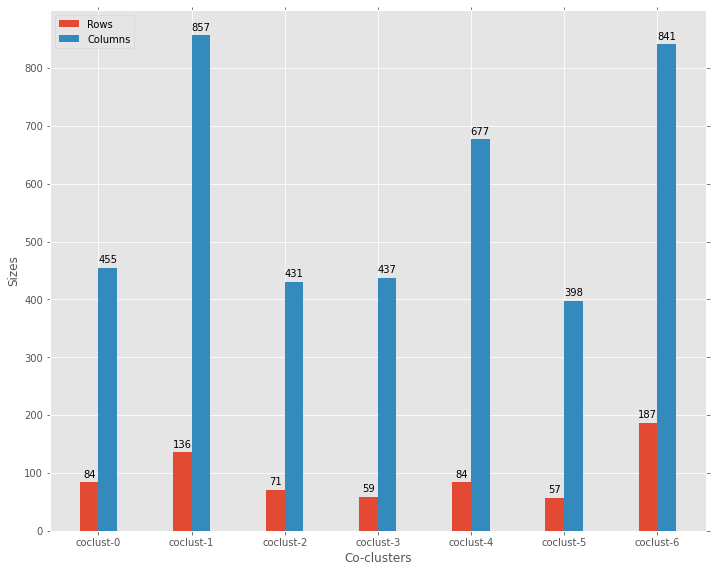

In [71]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,8)

from coclust.visualization import (plot_reorganized_matrix,
                                  plot_cluster_top_terms,
                                  plot_max_modularities,
                                  get_term_graph,
                                  plot_convergence)
# ** Plot top terms for each cluster and the cluster sizes **
n_terms = 20
# plot the reorganized matrix

plot_reorganized_matrix(X, model, markersize=0.9)
# --> top terms
plot_cluster_top_terms(X, all_terms_tfidf, n_terms, model)
# --> cluster sizes
print("taille de chaque cluster :")
plot_cluster_sizes(model)

In [72]:
# ** Plot the term graph for a given cluster of terms **
graph = get_term_graph(X,model, all_terms_tfidf, 1, 10, 5)

In [73]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});


<IPython.core.display.Javascript object>

In [74]:
 from IPython.display import Javascript
 #runs arbitrary javascript, client-side
 Javascript("""
            window.graph={};
            """.format(graph))

<IPython.core.display.Javascript object>

In [75]:
%%javascript
 require(['d3'], function(d3){
   //a weird idempotency thing
   $("#chart1").remove();
   //create canvas
   element.append("<div id='chart1'></div>");
   $("#chart1").width("1160px");
   $("#chart1").height("800px");        
   var margin = {top: 20, right: 20, bottom: 30, left: 40};
   var width = 1280 - margin.left - margin.right;
   var height = 800 - margin.top - margin.bottom;
   var svg = d3.select("#chart1").append("svg")
     .style("position", "relative")
     .style("max-width", "960px")
     .attr("width", width + "px")
     .attr("height", (height + 50) + "px")
     .call(d3.behavior.zoom().on("zoom", redraw))
     .append("g")
     .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
    
    
   function redraw() {
       svg.attr("transform",
                "translate(" + d3.event.translate + ")"
                + " scale(" + d3.event.scale + ")");
   }   
   var color = d3.scale.category20();
   var force = d3.layout.force()
     .charge(-500)
     //.linkDistance(5)
     .linkDistance(function(d) { return (1 - d.value); })
     .size([width, height]);
   var graph = window.graph;
   
   force
       .nodes(graph.nodes)
       .links(graph.links)
       .start();

   var link = svg.selectAll(".link")
       .data(graph.links)
       .enter().append("line")
       .attr("class", "link")
       .style("stroke", "#999;")
       .style("stroke-opacity", .6)
       .style("stroke-width", function(d) { return Math.sqrt(d.value); })
 
       .style("stroke", "blue");
   var node = svg.selectAll(".node")
       .data(graph.nodes)
       .enter().append("g")
       .attr("class", "node")
       .call(force.drag);
   
   node.append("circle")
       .attr("class", "node_circle")
       .attr("r", 8)
       .style("fill", function(d) { return color(d.group); });
   node.append("text")
       .attr("class", "node_text")
       .attr("dx", 12)
       .attr("dy", ".35em")
       .text(function(d) { return d.name });
   node.append("title")
       .text(function(d) { return d.name; });
   var node_text = svg.selectAll(".node_text");
   var node_circle = svg.selectAll(".node_circle");
   
   force.on("tick", function() {
     link.attr("x1", function(d) { return d.source.x; })
         .attr("y1", function(d) { return d.source.y; })
         .attr("x2", function(d) { return d.target.x; })
         .attr("y2", function(d) { return d.target.y; });
     node_circle.attr("cx", function(d) { return d.x; })
         .attr("cy", function(d) { return d.y; });
     
     node_text.attr("x", function(d) { return d.x; })
         .attr("y", function(d) { return d.y; });
   });
 });

<IPython.core.display.Javascript object>

# NER

In [76]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
import en_ner_bc5cdr_md
nlp = spacy.load("en_ner_bc5cdr_md")



     |████████████████████████████████| 125.1 MB 1.2 MB/s eta 0:00:01
  Using cached spacy-3.0.8-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.0 MB)
  Created wheel for en-ner-bc5cdr-md: filename=en_ner_bc5cdr_md-0.4.0-py3-none-any.whl size=125666882 sha256=996b469cd8112b483f2fbe5e90361d674f7b24dd0e65c9faa201d0c5e8b3e454
  Stored in directory: /home/kamel/.cache/pip/wheels/5e/d7/4a/3687ca1af324854b7edb76321c472a2743d778c28094ab2979
Successfully built en-ner-bc5cdr-md
ERROR: en-core-web-lg 3.2.0 has requirement spacy<3.3.0,>=3.2.0, but you'll have spacy 3.0.8 which is incompatible.
  Attempting uninstall: spacy
    Found existing installation: spacy 3.2.4
    Uninstalling spacy-3.2.4:
      Successfully uninstalled spacy-3.2.4


/home/kamel/.local/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [80]:

nlp = spacy.load("en_ner_bc5cdr_md")
clusters_terms=[]
for i in range(0,model.n_clusters):
    row_indices, col_indices = model.get_indices(i)
    clusters_terms.append(np.array(all_terms_tfidf)[col_indices])

In [102]:
deseases_per_cluster=  {}
desease=[]

for j in range(0,len(clusters_terms)):
    for i in clusters_terms[j]:
        doc = nlp(str(i))  
        word = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
        if len(word)!=0 : desease.append(word[0])
    deseases_per_cluster[j] =desease
    print("TERM_LIST ",j, " : " ,desease)
    desease=[]
 

TERM_LIST  0  :  ['anomaly', 'dyslipidaemia', 'fracture', 'haemorrhage', 'hyperglycaemia', 'hyperglycemia', 'hypertension', 'hypokalaemia', 'pandemic', 'parainfluenza', 'schizophrenia', 'tuberculosis']
TERM_LIST  1  :  ['arrhythmias', 'endotheliitis', 'hemorrhage', 'hyperandrogenism', 'hypercoagulable', 'hyperinsulinemia', 'hypertrophy', 'leukoencephalopathy', 'nausea', 'necrosis', 'periodontitis', 'sepsis', 'tumor', 'vasculitis']
TERM_LIST  2  :  ['abscess', 'anemia', 'apnea', 'asthenia', 'cholestasis', 'coagulopathy', 'fibrosis', 'hypercoagulability', 'hypofibrinolysis', 'hypoxia', 'lymphocytopenia', 'malignancy', 'rash', 'sarcopenia', 'spondylodiscitis', 'steatohepatitis', 'steatosis', 'stroke', 'thrombocytopenia', 'thromboembolic', 'thrombotic', 'tracheomalacia']
TERM_LIST  3  :  ['allergy', 'angioedema', 'canada', 'dyslipidemia', 'hdl', 'htn', 'hyperlipidaemia', 'hypertensive', 'hypoalbuminemia', 'infarction', 'jaundice', 'ketoacidosis', 'neuromyelitis', 'pox', 'scurvy', 'transami

In [82]:
for i in deseases_per_cluster:
    print(len(deseases_per_cluster[i])," deseases")

12  deseases
14  deseases
22  deseases
17  deseases
29  deseases
8  deseases
25  deseases


In [83]:
cluster1 = model.get_submatrix(X, 1)
p = cluster1.sum(0)
p

matrix([[0.15326068, 0.22040926, 0.21713486, 0.23954396, 0.50456925,
         0.57091718, 0.25133246, 0.35442391, 0.3853598 , 0.4223667 ,
         9.57415097, 0.61612089, 0.41529715, 0.53428086, 0.77638478,
         1.56254278, 0.74646256, 3.79474609, 0.62215856, 0.18874999,
         0.64430528, 0.27995205, 1.77394902, 0.75836386, 0.31261583,
         0.15290147, 2.08102119, 0.22477354, 0.31303665, 0.89383604,
         0.36924733, 0.15349758, 0.15326068, 0.7605321 , 0.27812873,
         0.77666306, 1.18620888, 1.09009341, 0.66544258, 0.87554758,
         0.3519679 , 0.2083241 , 0.19972193, 0.21588392, 0.11250359,
         0.27189582, 0.75301086, 4.91862422, 0.46572795, 0.17250565,
         1.42485935, 0.36239438, 0.18322687, 0.85380448, 0.38056347,
         0.21713486, 0.17847657, 0.10460618, 0.31321724, 0.69105328,
         0.14321971, 0.46551243, 0.09332289, 0.43543715, 0.24395347,
         0.26363375, 0.72104387, 0.35740802, 0.26556095, 0.35408126,
         0.44189875, 0.12213782, 0

In [85]:
def plot_cluster_deseases_terms(X, all_terms, deseases_per_cluster):
    pass
    

In [86]:
#plot_cluster_deseases_terms(X, all_terms_tfidf, deseases_per_cluster, model)

### Compute spectral co-clustering with the CoclustSpecMod approach 

In [87]:
# ** Compute spectral co-clustering with the CoclustSpecMod approach **

n_clusters = model.n_clusters
# Perform co-clustering
coclust_specMod_model = CoclustSpecMod(n_clusters=3, random_state=0)
coclust_specMod_model.fit(X)

/home/kamel/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


problem RAM si bcp d'articles

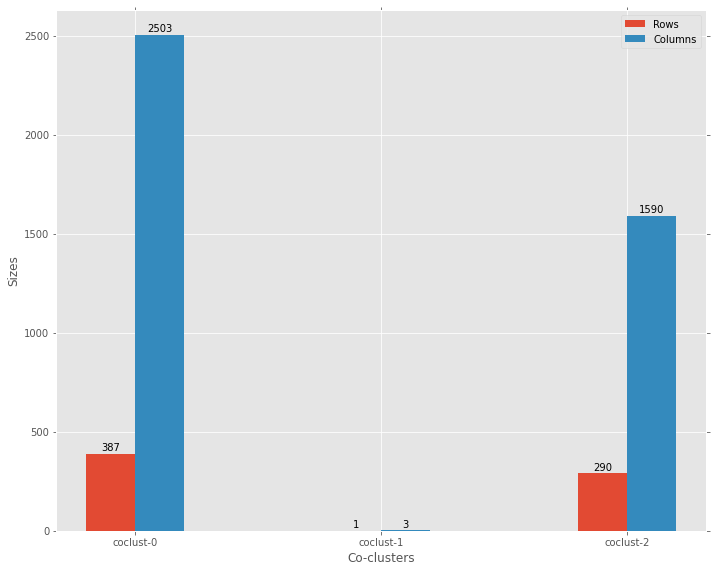

In [88]:
# ** Plot top terms for each cluster and the cluster sizes **

n_terms = 10

# --> top terms
#plot_cluster_top_terms(X, all_terms_tfidf, n_terms, coclust_specMod_model)
# --> cluster sizes
plot_cluster_sizes(coclust_specMod_model)

In [89]:
# > 2 co-cluster ca renvoie une err

In [90]:
len(all_terms_tfidf)

4096

### Compute spectral co-clustering with the CoclustInfo approach 

In [91]:
# ** Compute co-clustering with the CoclustInfo approach **

n_clusters = model.n_clusters
n_rand_init = 2
# Perform co-clustering
coclust_info_model = CoclustInfo(n_row_clusters = n_clusters, n_col_clusters = n_clusters,
                                 n_init = n_rand_init, random_state = 0)
coclust_info_model.fit(X)

CoclustInfo(n_col_clusters=7, n_init=2, n_row_clusters=7, random_state=0)

In [95]:
from sklearn.preprocessing import normalize
def get_term_graph_2(X, model, terms, n_cluster, n_top_terms=10, n_neighbors=2,
                   stopwords=[]):
    """Get a graph of terms.

    Parameters
    ----------
    X:
        input matrix
    model: :class:`coclust.coclustering.BaseDiagonalCoclust`
        a co-clustering model
    terms: list of string
        list of terms
    n_cluster: int
        Id of the cluster
    n_top_terms: int, optional, default: 10
        Number of terms
    n_neighbors: int, optional, default: 2
        Number of neighbors
    stopwords: list of string, optional, default: []
        Words to remove

    """

    # The dictionary to be returned
    graph = {"nodes": [], "links": []}

    if terms is None:
        logger.warning("Term labels cannot be found. Use input argument "
                       "'term_labels_filepath' in function "
                       "'load_doc_term_data' if term labels are available.")
        return graph
    factors = ["age","factor","severe","severity"]
    index_list = []
    for i in factors:
        index_list.append(terms.index(i))
        
    # get submatrix and local kist of terms
    row_indices, col_indices = model.get_indices(n_cluster)
    cluster = model.get_submatrix(X, n_cluster)
    terms = np.array(terms)[col_indices]

    # identify most frequent words
    p = cluster.sum(0)
    t = p.getA().flatten()
    top_term_indices = index_list

    # create tt sim matrix
    cluster_norm = normalize(cluster, norm='l2', axis=0, copy=True)
    sim = cluster_norm.T * cluster_norm

    # to be able to compute the final index of a neighbor which is also a
    # top term
    d = {t: i for i, t in enumerate(top_term_indices)}

    # identify best neighbors of frequent terms
    pointed_by = dict()
    graph = {"nodes": [], "links": []}
    all_neighbors = set()
    links = []
    for idx_tt, t in enumerate(top_term_indices):
        best_neighbors = np.argsort(sim.toarray()[t])[::-1][:n_neighbors]
        for n in best_neighbors:
            if len(stopwords) > 0:
                if terms[n] in stopwords:
                    continue
            if (terms[n].endswith("ed") or terms[n].endswith("ing") or
                    terms[n].endswith("ly")):
                continue

            # if  terms[dico_tt[n]].lower() in stopwords: continue
            if t == n:
                continue
            if n in top_term_indices and t in pointed_by.get(n, []):
                # t was already pointed by n
                continue
            if n in top_term_indices:
                # n will be able to check that is has been pointed by t
                pointed_by.setdefault(t, []).append(n)
            else:
                # a "pure" neighbor
                all_neighbors.add(n)
            if n in top_term_indices:
                # n is a (not yet handled) top term. Lookup in dictionary to
                # find the d3 index.
                # Also record original indices using couples.
                links.append(((idx_tt, t), (d[n], n)))
            else:
                # n is a pure neighbor. Compute its d3 index by an addition
                # use indices suitable for d3 links
                links.append(((idx_tt, t),
                              (len(top_term_indices) + len(all_neighbors) - 1,
                               n)))

    for top_term in top_term_indices:
        graph["nodes"].append({"name": terms[top_term], "group": 0})

    for neighbor in all_neighbors:
        graph["nodes"].append({"name": terms[neighbor], "group": 1})

    for a, b in links:
        graph["links"].append({"source": a[0],
                               "target": b[0],
                               "value": sim[a[1], b[1]]})
    return graph

In [96]:
graph2 = get_term_graph_2(X,model, all_terms_tfidf, 1, 10, 5)

IndexError: index 1421 is out of bounds for axis 0 with size 857

In [97]:
graph = get_term_graph(X,model, all_terms_tfidf, 0, 30, 5)

In [98]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});


<IPython.core.display.Javascript object>

In [99]:
 from IPython.display import Javascript
 #runs arbitrary javascript, client-side
 Javascript("""
            window.graph={};
            """.format(graph))

<IPython.core.display.Javascript object>

In [100]:
%%javascript
 require(['d3'], function(d3){
   //a weird idempotency thing
   $("#chart1").remove();
   //create canvas
   element.append("<div id='chart1'></div>");
   $("#chart1").width("1160px");
   $("#chart1").height("800px");        
   var margin = {top: 20, right: 20, bottom: 30, left: 40};
   var width = 1280 - margin.left - margin.right;
   var height = 800 - margin.top - margin.bottom;
   var svg = d3.select("#chart1").append("svg")
     .style("position", "relative")
     .style("max-width", "960px")
     .attr("width", width + "px")
     .attr("height", (height + 50) + "px")
     .call(d3.behavior.zoom().on("zoom", redraw))
     .append("g")
     .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
    
    
   function redraw() {
       svg.attr("transform",
                "translate(" + d3.event.translate + ")"
                + " scale(" + d3.event.scale + ")");
   }   
   var color = d3.scale.category20();
   var force = d3.layout.force()
     .charge(-500)
     //.linkDistance(5)
     .linkDistance(function(d) { return (1 - d.value); })
     .size([width, height]);
   var graph = window.graph;
   
   force
       .nodes(graph.nodes)
       .links(graph.links)
       .start();

   var link = svg.selectAll(".link")
       .data(graph.links)
       .enter().append("line")
       .attr("class", "link")
       .style("stroke", "#999;")
       .style("stroke-opacity", .6)
       .style("stroke-width", function(d) { return Math.sqrt(d.value); })
 
       .style("stroke", "blue");
   var node = svg.selectAll(".node")
       .data(graph.nodes)
       .enter().append("g")
       .attr("class", "node")
       .call(force.drag);
   
   node.append("circle")
       .attr("class", "node_circle")
       .attr("r", 8)
       .style("fill", function(d) { return color(d.group); });
   node.append("text")
       .attr("class", "node_text")
       .attr("dx", 12)
       .attr("dy", ".35em")
       .text(function(d) { return d.name });
   node.append("title")
       .text(function(d) { return d.name; });
   var node_text = svg.selectAll(".node_text");
   var node_circle = svg.selectAll(".node_circle");
   
   force.on("tick", function() {
     link.attr("x1", function(d) { return d.source.x; })
         .attr("y1", function(d) { return d.source.y; })
         .attr("x2", function(d) { return d.target.x; })
         .attr("y2", function(d) { return d.target.y; });
     node_circle.attr("cx", function(d) { return d.x; })
         .attr("cy", function(d) { return d.y; });
     
     node_text.attr("x", function(d) { return d.x; })
         .attr("y", function(d) { return d.y; });
   });
 });

<IPython.core.display.Javascript object>